![WoW Logo](assets/World_of_Warcraft_logo.jpg)

## Objective
* Complete Exploratory Data Analysis.
* Complete Survival Analysis.
* Predict if a user will churn in a six-month period using classification algorithms.

## Background Information
* World of Warcraft is a massively multiplayer online video game released on November 23, 2004. Before this era, MMORPG’s catered to a small segment of video gamers. But with the massive success of WoW, various video game companies decided to invest resources into developing large-scale titles. Video games were sought out as movie-like experiences, where you follow a single protagonist. However, WoW did not follow a single protagonist, but all the users playing the video game. Not only was the main objective different from single-player games, but the pricing model. Traditional games followed a single upfront fee. In addition to the single upfront fee, WoW had a monthly subscription to play the game. With customer subscriptions in mind, we can apply the use of churn prediction to not only predict whether a customer will unsubscribe from the service but explore the user’s playing behavior to obtain more insight into user playing patterns. The churn problem is somewhat complex due to the nature of not having a one size fits all solution – as different services define churn in a variety of ways.

## Process:
* Exploratory Data Analysis conducted utilizing various python packages (Numpy, Matplotlib, Pandas, and Plotly).'
* Survival Analysis (Lifelines)
    * Kaplan Meier Estimator
* Binary Classification Algorithms (Sci-Kit Learn)
    * Logistic Regression
    * Support Vector Machines
    * K-nearest neighbors
    * Random Forests



## Table of Contents:
* Part I: Exploratory Data Analysis
    * EDA
* Part II: Churn Prediction
    * Survival Analysis
    * Binary Classification

In [1]:
from lifelines import KaplanMeierFitter
from lifelines.plotting import rmst_plot
from sklearn import svm
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

# PART I - Exploratory Data Analysis

### Data Preprocessing / Feature Engineering

Let us begin by reading in the CSV file containing the data, and examining the data contents such as the number of features and the number of samples. It seems there are 7 column entries (features) and 10826734 row entries (number of samples).

In [2]:
#--------- Pandas Dataframe
## Read in CSV
avatar_history = pd.read_csv('data/wowah_data.csv')

## Examine data contents
avatar_history.info()
avatar_history.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10826734 entries, 0 to 10826733
Data columns (total 7 columns):
char          int64
 level        int64
 race         object
 charclass    object
 zone         object
 guild        int64
 timestamp    object
dtypes: int64(3), object(4)
memory usage: 578.2+ MB


,char,level,race,charclass,zone,guild,timestamp
0,59425,1,Orc,Rogue,Orgrimmar,165,01/01/08 00:02:04
1,65494,9,Orc,Hunter,Durotar,-1,01/01/08 00:02:04
2,65325,14,Orc,Warrior,Ghostlands,-1,01/01/08 00:02:04
3,65490,18,Orc,Hunter,Ghostlands,-1,01/01/08 00:02:04
4,2288,60,Orc,Hunter,Hellfire Peninsula,-1,01/01/08 00:02:09


* char = the character id
* level = level of the character
* race = race of the character
* charclass = class of the character
* zone = location at which the character is
* guild = guild id of the character
* timestamp = date and time at which the entry took place


Remove unwanted whitespace in column names.

In [3]:
# Strip whitespace in feature names
avatar_history.rename(columns = lambda x: x.strip(), inplace = True)
avatar_history.columns

Index(['char', 'level', 'race', 'charclass', 'zone', 'guild', 'timestamp'], dtype='object')

Split the date from the time from the timestamp feature.

In [4]:
def time_transform(x):
    "Function to split the date and time"
    y = x.split()[0]
    return y[:-2] + '20' + y[-2:]

In [5]:
## Create new features date and time using the function above
avatar_history['date'] = avatar_history['timestamp'].apply(time_transform)
avatar_history['time'] = avatar_history['timestamp'].apply(lambda x: x.split()[1][:-4] + '0')

The timestamps feature was converted into a DateTime object, allowing us to extract the month, day, and time of each entry. 

In [6]:
# Create datetime features 
avatar_history['timestamp'] = pd.to_datetime(avatar_history['timestamp'])
avatar_history['Month'] = avatar_history['timestamp'].dt.month
avatar_history['Day'] = avatar_history['timestamp'].dt.dayofyear
avatar_history['Weekday'] = avatar_history['timestamp'].dt.weekday

### Feature Exploration

The number of unique entries for each feature is organized in Table 1.  

In [ ]:
# Table of feature description
## Find the number of unique entries for each feature
number_of_characters = avatar_history['char'].nunique()
number_of_levels = avatar_history['level'].nunique()
number_of_races = avatar_history['race'].nunique()
number_of_classes = avatar_history['charclass'].nunique()
number_of_zones = avatar_history['zone'].nunique()
number_of_guilds = avatar_history['guild'].nunique()
number_of_timestamps = avatar_history['timestamp'].nunique()

## Append and print the unique entries for each feature
data = []
for x in avatar_history.columns:
    print("The number of unique " + str(x) + " is " + str(avatar_history[x].nunique()) + ".")
    data.append(avatar_history[x].nunique())

## Create table using plotly 
### Create an array and transpose values to make it a two-column format
data = np.array(data)
data = data.transpose()

### Create plotly table object
feature_information = go.Figure(data = [go.Table(
    header = dict(values = ['Unique Characters', 'Unique Levels',
                            'Unique Races', 'Unique Classes',
                            'Unique Zones', 'Unique Guilds',
                            'Unique Timestamps'],
                  line_color = 'darkslategray',
                  fill_color = 'lightskyblue',
                  align = 'left'),
    cells = dict(values = data,
                 line_color = 'darkslategray',
                 fill_color = 'lightcyan',
                 align = 'left'))
])

feature_information.update_layout(width = 800, height = 300, title = 'Table 1: Feature description')
feature_information.show()

### Level Distribution

Most players are level 1 with 11598 out of 37354 character entries. This can be explained by the use of alternate characters, which are used as mules in major towns to sell and trade items between others. Also, with such a right-skewed distribution it may be informative for game developers to put more effort into the level 1 – 30 zones. There appears to be a steady decrease from 1 to 60 until 70, which was the max level before the WOTLK expansion. Finally, a peak at 80, which is the latest max level. 

In [ ]:
# Plot the Distribution of Levels
## Create data segment - get the latest snapshot of levels
level_dist = avatar_history.groupby('char')['level'].max()

## Figure parameters
plt.figure(figsize = (20,10))
sns.set(style = "whitegrid", rc = {"lines.linewidth": 3})

ax = sns.distplot(level_dist, kde_kws = {"color": "green", "lw": 4, "label": "KDE"},
                  hist_kws = {"linewidth": 6,
                              "alpha": 1, "color": "pink",
                              'label': 'Histogram'})

plt.xlabel('Levels', fontsize = 24)
plt.ylabel('Frequency', fontsize = 24)
plt.title('Distribution of Levels', fontsize = 24)
number_of_ticks = [1, 10, 20, 30, 40, 50, 60, 70, 80]
plt.xticks(number_of_ticks, fontsize = 16)
plt.yticks(fontsize = 16)

## Add annotations for statistics
plt.text(80, 0.175, 'Min: ' + str(round(level_dist.value_counts().min(),1)) , size = 18, color = 'black')
plt.text(80, 0.185, 'Mean: ' + str(round(level_dist.value_counts().mean(),1)) , size = 18, color = 'black')
plt.text(80, 0.195, 'Max: ' + str(round(level_dist.value_counts().max(),1)) , size = 18, color = 'black')
plt.show()

In [9]:
def featureDistribution_DF(feature):
    """Acquires a sorted dataframe of a selected featue which is categorized by char ID"""
    feature_dist = avatar_history.groupby('char')[feature].max().value_counts()
    sorted_feature_dist = pd.DataFrame(feature_dist)
    sorted_feature_dist.columns = ['Count']
    sorted_feature_dist.index.names = [feature]
    return sorted_feature_dist

The zones which occupy WoW are not for individual levels but comprises level intervals. The top three level intervals are 0-9, 10 – 19, and 70-79. Such that having insight into how the population is divided in these intervals, further supports our initial reasoning to provide more development time in these early-level zones.

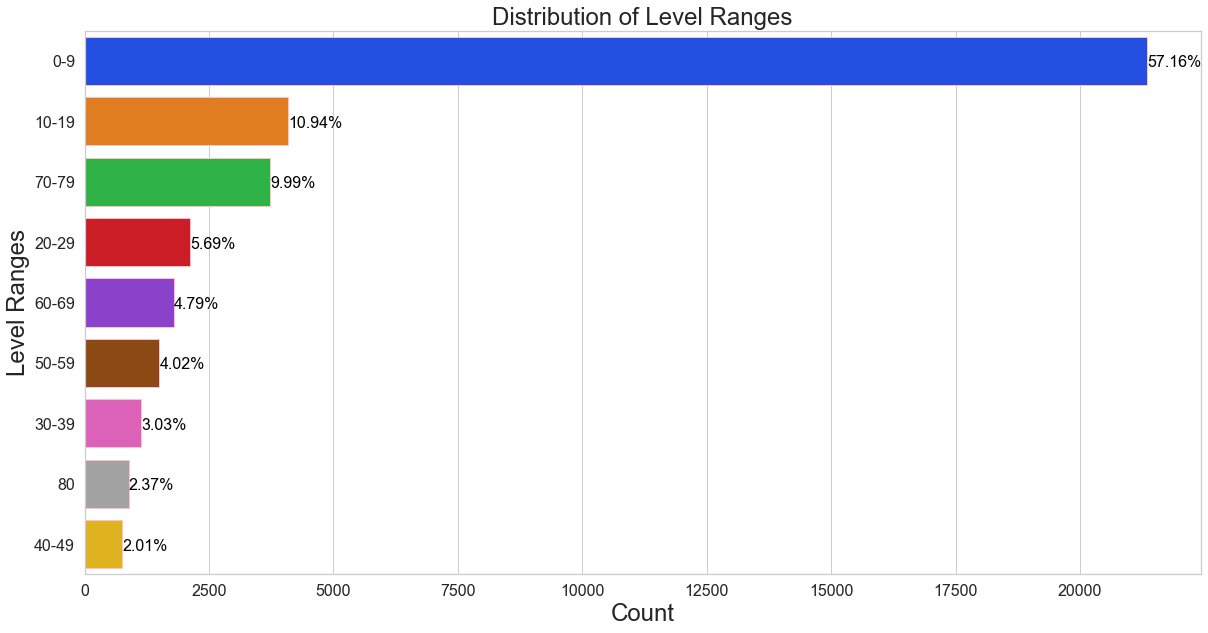

In [10]:
# Plot the level intervals 
## Discretize the levels into intervals
bins = np.array([0, 10, 20, 30, 40, 50, 60, 70, 80])

## Apply the bins and create a new feature level_intervals
avatar_history['level_interval'] = np.digitize(avatar_history['level'],bins)

mapped_levels = {1: '0-9', 2: '10-19',
     3: '20-29', 4: '30-39',
     5: '40-49', 6: '50-59',
     7: '60-69', 8: '70-79',
     9: '80'}

avatar_history['level_interval'] = avatar_history['level_interval'].map(mapped_levels)

## Create a sorted dataframe of the level_interval feature
sorted_level_interval_dist = featureDistribution_DF('level_interval')

## Plot parameters
plt.figure(figsize = (20,10))
sns.set(style = "whitegrid", rc = {"lines.linewidth": 3}, palette = 'bright')

ax = sns.barplot(x = sorted_level_interval_dist['Count'],
                 y = sorted_level_interval_dist.index, 
                 edgecolor = 'pink')

plt.xlabel('Count', fontsize = 24)
plt.ylabel('Level Ranges', fontsize = 24)
plt.title('Distribution of Level Ranges', fontsize = 24)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

'''Annotates a plot with percentages vertical layout.'''
# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width() + .3, i.get_y() + .50, \
            str(round((i.get_width() / total) * 100, 2)) + '%', fontsize = 16,
color = 'black')
plt.show()

When players create their characters, they have a choice in selecting the race and class. Having data on their selections provides developers with insight to properly manage what classes should be monitored more and helps the game balance team to decide on why these certain classes or races are picked – Are they strong, weak, or people enjoy the themes of the classes. Should we spend more time on their race-specific starting zones due to their selection? The player base selects Blood Elves, Warriors, and Orc Warriors, as their popular choices in races, classes, and race-class combinations, respectively.    

### Race Distribution

In [ ]:
# Plot the race distribution
sorted_race_dist = featureDistribution_DF('race')

## Plot parameters
plt.figure(figsize = (20,10))
textprops = dict(size = 22 )
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99', '#ffb3cc']

plt.pie(sorted_race_dist['Count'], labels = sorted_race_dist.index,
        autopct = '%1.1f%%', startangle = 90, textprops = textprops, colors = colors)

plt.title('Distribution of Races', fontsize = 24)
plt.axis('equal') 
plt.tight_layout()
plt.show()

### Class Distributions

In [ ]:
# Plot the class distribution
sorted_class_dist = featureDistribution_DF('charclass')

## Plot Parameters
plt.figure(figsize = (20,10))
sns.set(style = "whitegrid", rc = {"lines.linewidth": 3}, palette = 'bright')
ax = sns.barplot( x = sorted_class_dist['Count'],
                  y = sorted_class_dist.index, edgecolor = 'pink')
plt.xlabel('Count', fontsize = 24)
plt.ylabel('Classes', fontsize = 24)
plt.title('Distribution of Classes', fontsize = 24)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

'''Annotates a plot with percentages vertical layout.'''
# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width() + .3, i.get_y() + .50, \
            str(round((i.get_width() / total) * 100, 2)) + '%', fontsize = 16,
color = 'black')
plt.show()

### Race + Class Combinations

In [ ]:
# Plot the popular class / race combinations
## Create dataframes for the race and class combinations
race_class_dist = avatar_history.groupby('char')['race', 'charclass'].max()
tmp_df = pd.DataFrame(race_class_dist)
tmp_df.columns = ['Race', 'Class']
tmp_df.index.names = ['charID']

race_class_df = pd.DataFrame(tmp_df['Class'].values.astype(str),
             tmp_df['Race'].values.astype(str), columns = ['Class'])

race_class_df.index.names = ['Race']

## Apply a whitespace to combine both race and class features
race_class_df['Class']= race_class_df['Class'].apply(lambda x: "{}{}".format(' ', x))

## Create the new race+class feature
race_class_df['race+class'] = race_class_df.index.str.cat(race_class_df.values)

## Sort by frequency 
ah_pop = race_class_df.assign(freq = race_class_df.groupby('race+class')['race+class'].transform('count'))\
  .sort_values(by = ['freq','race+class'],ascending = [False,True]).loc[:,['race+class']]

## Plot parameters
plt.figure(figsize = (20,10))
sns.set(style = "whitegrid", rc = {"lines.linewidth": 3}, palette = 'bright')
ax = sns.countplot( y = ah_pop['race+class'], palette = 'bright', edgecolor = 'pink' )
plt.xlabel('Count', fontsize = 24)
plt.ylabel('Races and Classes', fontsize = 24)
plt.title('Distribution of Race and Class Combinations', fontsize = 24)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 14)

'''Annotates a plot with percentages vertical layout.'''
# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width(), i.get_y() + 0.9, \
            str(round((i.get_width()/total)*100, 2))+'%', fontsize = 16,
color = 'black')
plt.show()

Identifying population bottlenecks is important for optimizing server stability, but investigating which zones are populated is crucial in delegating resources into what aspects of the game players are enjoying. The game is divided into Player vs Environment and Player vs Player content. The top two zones are hubs where players can trade items or sign up for quests. The third is a major PvE raid dungeon where players embark on a quest to clear the opposing forces.    

### Top 20 Popular Zones

In [ ]:
# Plot the top 20 popular zones
## Sort by frequent zones
ah_zf = avatar_history.assign(freq = avatar_history.groupby('zone')['zone'].transform('count'))\
  .sort_values(by = ['freq','zone'],ascending = [False , True]).loc[:,['zone']]

## Create dataframe for top 20 popular zones
zone_dist = ah_zf['zone'].value_counts()
sorted_zone_dist = pd.DataFrame(zone_dist)
sorted_zone_dist.columns = ['Count']
sorted_zone_dist.index.names = ['zone']

## Plot the expected variance
plt.figure(figsize = (20, 10))
sns.set(style = "whitegrid", rc = {"lines.linewidth": 2})
ax = sns.barplot( x = sorted_zone_dist['Count'][0:20],
                  y = sorted_zone_dist.index[0:20], palette = 'bright', edgecolor = 'pink')
plt.xlabel('Count', fontsize = 24)
plt.ylabel('Zones', fontsize = 24)
plt.title('Top 20 Popular Zones', fontsize = 24)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

'''Annotates a plot with percentages vertical layout.'''
# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches[0:20]:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches[0:20]:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width(), i.get_y() + 0.6, \
            str(round((i.get_width() / total) *100, 2)) + '%', fontsize = 16,
color = 'black')
plt.show()

### Guild Distribution

There are roughly 500 guilds created - The largest guild has a population of 1796 members, and the average guild has 73 members. Similar to the class distribution in earlier, guilds follow the same breakdown. Higher-level content requires an abundant amount of people requiring 25 or more and use guilds as a way to gather people. Not only are guilds used for completing WoW activities, but many users have it function as a social community to keep in touch with their online friends.

In [ ]:
# Guild distribution and guild-class Distribution
## Select entries that are in a guild
in_a_guild = avatar_history[avatar_history['guild'] != -1]

## Group playerbase by character char id, guild, and class
tmp = in_a_guild.groupby(['char'])['guild','charclass'].max()

## Find guild indices with 10 or more players
guild_list = tmp['guild'].value_counts()[tmp['guild'].value_counts() >= 10].index

## Create guild_class dataframe
data =  {'guild_id': tmp['guild'].values ,
         'class': tmp['charclass'].values,
        }

guild_class_df = pd.DataFrame(data)

## Apply those guild_list indices to our dataframe
guild_class_df = guild_class_df[guild_class_df['guild_id'].isin(guild_list)]

In [ ]:
# Plot the guild population distribution
## Plot parameters
plt.figure(figsize = (20,10))
sns.set(style = "whitegrid", rc = {"lines.linewidth": 3},  palette = 'bright')
ax = sns.distplot(guild_class_df['guild_id'], kde_kws = {"color": "green", "lw": 4, "label": "KDE"},
                  hist_kws = {"linewidth": 6,
                              "alpha": 1, "color": "pink",
                              'label': 'Histogram'})

plt.xlabel('Guild IDs', fontsize = 24)
plt.ylabel('Frequency', fontsize = 24)
plt.title('Guild Populations', fontsize = 24)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

# Add annotations for statistics
plt.text(501, 0.00702,
         'Min: ' + str(round(guild_class_df['guild_id'].value_counts().min(),1)),
         size = 18, color = 'black')
plt.text(501, 0.0073,
         'Mean: ' + str(round(guild_class_df['guild_id'].value_counts().mean(),1)),
         size = 18, color = 'black')
plt.text(501, 0.0076,
         'Max: ' + str(round(guild_class_df['guild_id'].value_counts().max(),1)),
         size = 18, color = 'black')

plt.show()

In [ ]:
# Plot the class distribution in guilds
## Plot parameters
plt.figure(figsize = (20,10))
sns.set(style = "whitegrid", rc = {"lines.linewidth": 3},  palette = 'bright')

ax = sns.barplot(y = ['Warrior', 'Hunter',
                      'Rogue', 'Mage',
                      'Warlock', 'Paladin',
                      'Shaman', 'Priest',
                      'Druid', 'Death Knight'],
                 x = guild_class_df['class'].value_counts()
                )

plt.xlabel('Count', fontsize = 24)
plt.ylabel('Classes', fontsize = 24)
plt.title('Class distribution in guilds', fontsize = 24)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

'''Annotates a plot with percentages vertical layout.'''
# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width() + .3, i.get_y() + .50, \
            str(round((i.get_width() / total) * 100, 2)) + '%', fontsize = 16,
color = 'black')

There is a steady equilibrium of players between 70-79 having the highest frequency because the max level before November was 70. The max level was increased to 80 in November. Similar fluctuations are observed within the other leveling intervals between January and September, but a sharp peak in the 0-9 interval arises during October. A possible reason is the arrival of new players who are awaiting the expansion release in November.   

### Daily Active Users

In [ ]:
def time_transform(x):
    "Function to split the date and time"
    y = x.split()[0]
    return y[:-2] + '20' + y[-2:]

In [ ]:
## Create new features date and time using the function above
avatar_history['date'] = avatar_history['timestamp'].apply(time_transform)
avatar_history['time'] = avatar_history['timestamp'].apply(lambda x: x.split()[1][:-4] + '0')

In [ ]:
# Plot the daily active users
## Create pivot table to aggregate the number of users in each specific level interval.
dau_pvt = avatar_history.pivot_table(index = 'date',
                            columns = ['level_interval'],
                            values = 'char',
                            aggfunc = lambda x: x.value_counts().count()).fillna(0).astype(int)
dau_pvt.reset_index(inplace=True)

## Variables to extract all dates and account for missing dates in the pivot table
all_dates = pd.Series(pd.date_range('01/01/08', freq = 'D', periods = 365))
all_dates = all_dates.dt.strftime('%m/%d/%Y')
missing_dates = list(set(all_dates) - set(dau_pvt.index.unique()))
add_df = pd.DataFrame(columns = ['date'])
add_df['date'] = missing_dates
dau_pvt['date'] = pd.to_datetime(dau_pvt['date'])
dau_pvt.sort_values(by=['date'], inplace = True)
dau_pvt.reset_index(drop = True, inplace = True)
dau_pvt['date'] = dau_pvt['date'].dt.strftime('%m/%d/%Y')


## Plotly go object to plot the graph.
fig = go.Figure()

## Set colors of curves
colormap = ['purple', 'orange',
            'green', 'blue',
            'teal', 'red',
            'black', 'pink',
            'yellow']

## Set leveling intervals of curves
columns = [ '0-9', '10-19',
           '20-29', '30-39',
           '40-49', '50-59',
           '60-69', '70-79',
           '80']

## Plot each leveling curve with a respective color
for color, column in zip(colormap, columns):
    fig.add_trace(go.Scatter(
                    x = dau_pvt['date'],
                    y = dau_pvt[column],
                    name = column,
                    line_color = color,
                    hoverinfo = 'name+x+y',
                    opacity = 0.8))
fig.update_layout(title_text = "Daily User Activity over one-year", 
                 xaxis = dict(
                     tickmode = 'array',
                     ## Place tick labels and locations
                     ticktext = ['Jan', 'Feb',
                                 'Mar', 'Apr',
                                 'May', 'Jun',
                                 'Jul', 'Aug',
                                 'Sep', 'Oct',
                                 'Nov', 'Dec'],
                     
                     tickvals = [1, 31,
                                 60, 91,
                                 121, 152,
                                 182, 213,
                                 244, 274,
                                 304, 335]
                 ),
                  xaxis_rangeslider_visible = True)
fig.show()

### Monthly Active Users

In [ ]:
# Plot monthly active users
## Create pivot table to aggregate the number of users in each specific level interval.
mau_pvt = avatar_history.pivot_table(index = 'date',
                            columns = ['level_interval'],
                            values = 'char',
                            aggfunc = lambda x: x.value_counts().count()).fillna(0).astype(int)

mau_pvt.reset_index(inplace = True)

## Variables to extract all dates and account for missing dates in the pivot table
all_dates = pd.Series(pd.date_range('01/01/08', freq = 'D', periods = 365))
all_dates = all_dates.dt.strftime('%m/%d/%Y')
missing_dates = list(set(all_dates) - set(mau_pvt.index.unique()))
add_df = pd.DataFrame(columns=['date'])
add_df['date'] = missing_dates
mau_pvt['date'] = pd.to_datetime(mau_pvt['date'])
mau_pvt.sort_values(by = ['date'], inplace = True)
mau_pvt.reset_index(drop = True, inplace = True)
mau_pvt['date'] = mau_pvt['date'].dt.strftime('%m/%d/%Y')

## Map the months
mau_pvt['date'] = (pd.to_datetime(mau_pvt['date']))

d = {1: 'January', 2: 'February',
     3: 'March', 4: 'April',
     5: 'May', 6: 'June',
     7: 'July', 8: 'August',
     9: 'September', 10: 'October',
     11: 'November', 12: 'December'}

## Create the months dataframe for MAU
mau_pvt['Month'] = mau_pvt['date'].dt.month.map(d)

## Create label list for months
yourlabels_list = [ 'January', 'February',
                   'March',  'April',
                   'May', 'June',
                   'July',  'August',
                   'September',  'October',
                   'November',  'December']

sum_months = mau_pvt.groupby('Month').sum()
sorted_sum_month = pd.DataFrame(sum_months)

sorted_sum_month.columns = [ '0-9', '10-19',
                            '20-29', '30-39',
                            '40-49', '50-59',
                            '60-69',  '70-79',
                            '80']

sorted_sum_month.index.names = ['Month']
sorted_sum_month = sorted_sum_month.reindex(yourlabels_list)

## Plotly go object to plot the graph.
fig = go.Figure()

## Set colors for each curve
colormap = ['purple', 'orange',
            'green', 'blue',
            'teal', 'red',
            'black', 'pink',
            'yellow']

## Set leveling intervals of curves
columns = [ '0-9', '10-19',
           '20-29', '30-39',
           '40-49', '50-59',
           '60-69', '70-79',
           '80']

## Plot each leveling curve with a respective color
for color, column in zip(colormap, columns):
    fig.add_trace(go.Scatter(
                    x = sorted_sum_month.index,
                    y = sorted_sum_month[column],
                    name = column,
                    line_color = color,
                    hoverinfo = 'name+x+y',
                    opacity = 0.8))
fig.update_layout(title_text = "Monthly User Activity over one-year", 
                 xaxis = dict(
                     tickmode = 'array',              
                     
                 ),
                  xaxis_rangeslider_visible = True)
fig.show()

From observing the HAU, there is a steady decrease until 7:00 am and then elevates during the afternoon because teenagers arrive from school. Then, a steady increase in the evening from 5:00 pm until 12:00 pm because adults arrive from work. The highest frequency of users is during the evening hours. The average user plays for 1 hour daily, and the 95% percentile of players play for 4 hours daily. Having this knowledge allows us to properly address times in which the servers need to be taken down for maintenance, and how to pace future content updates for the average user’s playtime - do not want to release content which the average user cannot finish. Most users are recorded playing on Sunday, and the other days of the week are in similar in frequency. We’d expect most players to play on the weekend to account for not having work obligations.

### Hourly User Activity

In [ ]:
# Plot hourly user activity
## Create daily session dataframes
tmp = avatar_history.groupby(by = ['date', 'time'])['char'].nunique().to_frame('char').reset_index()
day_activity_mean = round(tmp.groupby(['time'], as_index = False)['char'].mean())
day_activity_max = round(tmp.groupby(['time'], as_index = False)['char'].max())

## Plotly go object to graph plot.
fig = go.Figure()

## Mean
fig.add_trace(go.Scatter(
    x = day_activity_mean['time'],
    y = day_activity_mean['char'],
    name = 'Average',
    line_color = 'red',
    hoverinfo = 'name+x+y',
    opacity = 0.8))

## Max 
fig.add_trace(go.Scatter(
    x = day_activity_max['time'],
    y = day_activity_max['char'],
    name = 'Max',
    line_color = 'purple',
    hoverinfo = 'name+x+y',
    opacity = 0.8))

fig.update_layout(title_text = "Hourly User Activity over one-year", 
                  xaxis = dict(
                      tickvals = [0, 6, 12, 18, 24, 30,
                                  36, 42, 48, 54, 60,
                                  66, 72, 78, 84, 90,
                                  96, 102, 108, 114, 120,
                                  126, 132, 138, 144],
                  ),
                  xaxis_rangeslider_visible = True)
fig.show()

### Daily Playtime

In [ ]:
#### Average hours played
# Group playerbase by character ID for average hours
tmp = avatar_history.groupby(by = ['char'])['Day'].nunique()

# Group playerbase by character ID for the number of unique days they have played
total_timestamps = avatar_history.groupby(by = ['char'])['Day'].count()

# Create dataframe for average_hours
data =  {'char_id': tmp.index,
         'total_timestamps': total_timestamps.values,
         'unique_days': tmp.values
        }

average_hours_df = pd.DataFrame(data = data)

# Create average_hour feature
average_hours_df['Average_Hour'] = average_hours_df['total_timestamps'] * 10 / (60 * average_hours_df['unique_days'])

# Plot the Average hours played
plt.figure(figsize = (20,10))

x = ['95% Percentile', '75% Percentile',
     'Mean',  '50% Percentile',
     '25% Percentile']

y = [average_hours_df['Average_Hour'].quantile(0.95),
     average_hours_df['Average_Hour'].quantile(0.75),
     average_hours_df['Average_Hour'].mean(),
     average_hours_df['Average_Hour'].quantile(0.50),
     average_hours_df['Average_Hour'].quantile(0.25)]

def absolute_value(val):
    a  = str(round(val / 100 * 6.971746263215458, 3)) + " hrs"
    return a

# Create pie chart
textprops = dict(size = 20 )
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99', '#ffb3cc']
plt.pie(y, labels = x,
        autopct = absolute_value, startangle = 180, textprops = textprops, colors = colors)
plt.axis('equal') 
plt.tight_layout()
plt.title('Daily Playtime', fontsize = 24)
plt.show()

### User Frequency on Weekdays

In [ ]:
# Plot user frequency on weekdays
## Create dataframe for most frequent day of the week
tmp = avatar_history.groupby(by =['char'])['Weekday'].max().value_counts()

data =  {'weekday': tmp.index,
         'count': tmp.values
        }

weekdays_df = pd.DataFrame(data = data)

## Map weekday
d = {0: 'Monday', 1: 'Tuesday',
     2: 'Wednesday', 3: 'Thursday',
     4: 'Friday', 5: 'Saturday',
     6: 'Sunday'}

weekdays_df['weekday'] = weekdays_df['weekday'].map(d)
tmp = weekdays_df

## Plot the expected variance
plt.figure(figsize = (20, 10))
sns.set(style = "whitegrid", rc = {"lines.linewidth": 2})

order = ['Monday', 'Tuesday', 
         'Wednesday', 'Thursday',
         'Friday', 'Saturday',
         'Sunday']

ax = sns.barplot(y = weekdays_df['weekday'], x = weekdays_df['count'],
                 order = order,  palette = 'bright',
                 edgecolor = 'pink')

plt.xlabel('Count', fontsize = 24)
plt.ylabel('Weekdays', fontsize = 24)
plt.title('Distribution of Weekdays', fontsize = 24)
plt.xticks( fontsize = 16)
plt.yticks( fontsize = 16)

'''Annotates a plot with percentages vertical layout.'''
# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width(), i.get_y() + 0.5, \
            str(round((i.get_width()/total)*100, 2))+'%', fontsize = 16,
color = 'black')
plt.show()

# Part II: Prediction

The main objective of survival analysis is to provide an accurate experimental analysis when the collected data has not been completed. It was inspired for applications concerning clinical trials in the diagnosis of illnesses, and how to properly classify patients if they do not exhibit symptoms during the lifetime of the study. 

## Survival Analysis

Before KM survival analysis, the data was filtered discard users who are on a trial period and have not subscribed yet (< 30 days). Also, various churn periods were assigned to a user if they did not play in 2, 3, 4, or 6-month periods. 

In [ ]:
# Survival Analysis
## Feature creation
### Earliest day and latest day of the year played
tmp_day_earliest = avatar_history.groupby('char')['Day'].min()
tmp_day_latest = avatar_history.groupby('char')['Day'].max()

### Earliest month and Latest month of year played 
tmp_month_earliest = avatar_history.groupby('char')['Month'].min()
tmp_month_latest = avatar_history.groupby('char')['Month'].max()

### Unique amount of days played
tmp_days = avatar_history.groupby('char')['Day'].nunique()

### Are they in a guild or not
tmp_guild = avatar_history.groupby('char')['guild'].max()

### Max level
tmp_level = avatar_history.groupby('char')['level_interval'].max()

### Need this for the number of unique days played
tmp_timestamps = avatar_history.groupby(by = ['char'])['Day'].count()

# Create dataframe
data =  {'Char_ID': tmp_month_latest.index,
         'Unique_Days': tmp_days.values,
         'Total_Timestamps': tmp_timestamps.values,
         'Earliest_Month_Played': tmp_month_earliest.values,
         'Latest_Month_Played': tmp_month_latest.values,
         'Earliest_Day_Played': tmp_day_earliest.values,
         'Latest_Day_Played': tmp_day_latest.values,
         'Guild': tmp_guild.values,
         'Max_Level': tmp_level.values
        }

sa_total = pd.DataFrame(data)

### Difference in latest day played and earliest day played and absolute value to find the total subscribed time.
sa_total['Difference'] = (sa_total['Latest_Day_Played'] - sa_total['Earliest_Day_Played']).abs()

### Filter out the data whom have lower than 30 days of played time (free-trial accounts)
sa_total = sa_total.loc[(sa_total['Difference'] > 30)]
sa_total['Guild'] = sa_total['Guild'].apply(lambda x: 0 if x == -1 else 1)

### Create average_hour feature
sa_total['Average_Hour'] = sa_total['Total_Timestamps'] * 10 / (60 * sa_total['Unique_Days'])

### Create playing density
sa_total['Average_Playing_Density'] = sa_total['Unique_Days']/ (((sa_total['Latest_Month_Played'] - sa_total['Earliest_Month_Played'] + 1).abs())/12 * 366)

### Classify churn as someone who hasn't logged in various periods, 2, 3, 4, 6
#### 2 month period
sa_total['Churn2'] = (sa_total['Latest_Month_Played'] >= 11 )
sa_total['Churn2'] = sa_total['Churn2'].apply(lambda x: 0 if x == True else 1)

#### 3 month period
sa_total['Churn3'] = (sa_total['Latest_Month_Played'] >= 10)
sa_total['Churn3'] = sa_total['Churn3'].apply(lambda x: 0 if x == True else 1)

#### 4 month period
sa_total['Churn4'] = (sa_total['Latest_Month_Played'] >= 9)
sa_total['Churn4'] = sa_total['Churn4'].apply(lambda x: 0 if x == True else 1)

#### 6 month period
sa_total['Churn6'] = (sa_total['Latest_Month_Played'] >= 7)
sa_total['Churn6'] = sa_total['Churn6'].apply(lambda x: 0 if x == True else 1)

### Churn Periods

The data appears to be heavily right-censored and does converge to a constant instead of reaching to 0. The 2-month and 3-month churn periods provide more accurate results due to less censoring than the other survival curves. The 2-month churn period has a 70% probability of not churning for ~215 days, and the 3-month period has a 60% probability of not churning for ~245 days. These results display promising insights into how addictive this game is as the population will be healthy across ~200 days. 

In [ ]:
# Survival Analysis
## Kaplan-Meier Analysis
### KMF
kmf = KaplanMeierFitter()

### Plot Parameters
sns.set_context("talk")
ax = plt.subplot()
plt.xlabel('Duration (Days)', fontsize = 18)
plt.title('Kaplan-Meier Estimate of Customer Retention by Churn Periods', fontsize = 24)
plt.xlabel('Duration (Days)', fontsize = 18)
plt.ylabel("Probability a Player is Still Active")

### Plotting KM curves with various churn periods
churn_list = ['Churn2', 'Churn3', 'Churn4', 'Churn6']
churn_labels = ['2-month churn period', '3-month churn period', '4-month churn period', '6-month churn period']
colormap = ['red', 'blue', 'green', 'orange']
for churn, label, color in zip(churn_list, churn_labels, colormap):
    kmf.fit(sa_total['Difference'], sa_total[churn], label = label)
    kmf.plot(figsize = (18,9), ax = ax, color = color)
    
### Plotting Annotations
plt.vlines(303, ymin= 0.40, ymax= 0.46, linestyle = 'dotted', color = 'red')
plt.vlines(273, ymin= 0.40, ymax= 0.59, linestyle = 'dotted', color = 'blue')
plt.vlines(243, ymin= 0.40, ymax= 0.67, linestyle = 'dotted', color = 'green')
plt.vlines(177, ymin= 0.40, ymax= 0.81, linestyle = 'dotted', color = 'orange')
plt.text(276, 0.40, '30 days', color = 'red')
plt.text(246, 0.40, '30 days', color = 'blue')
plt.text(186, 0.40, '60 days', color = 'green', fontsize = 38)
plt.show()

### Guilds

People who are not in a guild have a 1.33x higher churn ratio because being in a social network - can interact and group with your guildmates when playing the game. 

In [ ]:
# Survival Analysis
## Kaplan-Meier Analysis
### KMF
kmf = KaplanMeierFitter()

### Plotting parameters
sns.set_context("talk")
ax = plt.subplot()
plt.xlabel('Duration (Days)', fontsize = 18)
plt.title('Kaplan-Meier Estimate of Customer Retention by Guild', fontsize = 24)
plt.xlabel('Duration (Days)', fontsize = 18)
plt.ylabel("Probability a Player is Still Active")

### Plotting KM curves if they are in a guild or not
T_0 = sa_total[sa_total['Guild'] == 0]['Difference']
C_0 = sa_total[sa_total['Guild'] == 0]['Churn2']
T_1 = sa_total[sa_total['Guild'] == 1]['Difference']
C_1 = sa_total[sa_total['Guild'] == 1]['Churn2']

time_limit = 303
labels = ['Guild', 'No Guild']
colormap = ['red', 'blue']
duration = [T_0, T_1]
event = [C_0, C_1]
position = [(100, 0.4), (180, 0.6)]

for T, C, label, label_position, color in zip(duration, event, labels, position, colormap):
    kmf.fit(T, C, label = label)
    kmf.plot(figsize = (18,9), ax = ax, color = color)
    rmst_plot(figsize = (18,9), model = kmf,
          t = time_limit, ax = ax,
          label = '_nolegend_', text_position = label_position)

plt.show()

In [ ]:
print("Guild Churn Ratio: " + str((242.407/182.265)))

### Level Intervals

There is a significant overlap between curves. Therefore, let’s compare each curve with the 70-79 range to compare the churn ratios. The churn ratios are listed in Table 2. An interesting detail is the survival analysis curve for the 10-19 interval has a higher churn ratio than the other intervals. A possible solution is updating the 10-19 range content to compensate for this higher churn ratio. 

In [ ]:
# Survival Analysis
## Kaplan-Meier Analysis
### KMF
kmf = KaplanMeierFitter()

### Plotting parameters
sns.set_context("talk")
ax = plt.subplot()
plt.xlabel('Duration (Days)', fontsize = 18)
plt.title('Kaplan-Meier Estimate of Customer Retention by Levels', fontsize = 24)
plt.xlabel('Duration (Days)', fontsize = 18)
plt.ylabel("Probability a Player is Still Active", fontsize = 18)

### Plotting KM curves if they are in a guild or not
T_09 = sa_total[sa_total['Max_Level'] == '0-9']['Difference']
C_09 = sa_total[sa_total['Max_Level'] == '0-9']['Churn2']
T_1019 = sa_total[sa_total['Max_Level'] == '10-19']['Difference']
C_1019 = sa_total[sa_total['Max_Level'] == '10-19']['Churn2']
T_2029 = sa_total[sa_total['Max_Level'] == '20-29']['Difference']
C_2029 = sa_total[sa_total['Max_Level'] == '20-29']['Churn2']
T_3039 = sa_total[sa_total['Max_Level'] == '30-39']['Difference']
C_3039 = sa_total[sa_total['Max_Level'] == '30-39']['Churn2']
T_4049 = sa_total[sa_total['Max_Level'] == '40-49']['Difference']
C_4049 = sa_total[sa_total['Max_Level'] == '40-49']['Churn2']
T_5059 = sa_total[sa_total['Max_Level'] == '50-59']['Difference']
C_5059 = sa_total[sa_total['Max_Level'] == '50-59']['Churn2']
T_6069 = sa_total[sa_total['Max_Level'] == '60-69']['Difference']
C_6069 = sa_total[sa_total['Max_Level'] == '60-69']['Churn2']
T_7079 = sa_total[sa_total['Max_Level'] == '70-79']['Difference']
C_7079 = sa_total[sa_total['Max_Level'] == '70-79']['Churn2']

time_limit = 303

labels = ['0-9', '10-19',
          '20-29', '30-39',
          '40-49', '50-59',
          '60-69', '70-79']

colormap = ['red', 'blue',
            'magenta', 'orange',
            'teal', 'purple',
            'green', 'pink']

duration = [T_09, T_1019, T_2029, T_3039, T_4049, T_5059, T_6069, T_7079] 
event = [C_09, C_1019, C_2029, C_3039, C_4049, C_5059, C_6069, C_7079]

for T, C, label, color in zip(duration, event, labels, colormap):
    kmf.fit(T, C, label = label)
    kmf.plot(figsize = (18,9), ax = ax, color = color, ci_show = True )

plt.show()

In [ ]:
# Survival Analysis
## Kaplan-Meier Analysis
### KMF
kmf = KaplanMeierFitter()

### Plot parameters
sns.set_context("talk")
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(figsize = (20, 10), nrows=2,
                                                                 ncols=4, sharex=True,
                                                                 sharey=True)
fig.suptitle('Kaplan-Meier Estimate of Customer Retention by Levels')

# Plotting KM curves at various levels
T_09 = sa_total[sa_total['Max_Level'] == '0-9']['Difference']
C_09 = sa_total[sa_total['Max_Level'] == '0-9']['Churn2']
T_1019 = sa_total[sa_total['Max_Level'] == '10-19']['Difference']
C_1019 = sa_total[sa_total['Max_Level'] == '10-19']['Churn2']
T_2029 = sa_total[sa_total['Max_Level'] == '20-29']['Difference']
C_2029 = sa_total[sa_total['Max_Level'] == '20-29']['Churn2']
T_3039 = sa_total[sa_total['Max_Level'] == '30-39']['Difference']
C_3039 = sa_total[sa_total['Max_Level'] == '30-39']['Churn2']
T_4049 = sa_total[sa_total['Max_Level'] == '40-49']['Difference']
C_4049 = sa_total[sa_total['Max_Level'] == '40-49']['Churn2']
T_5059 = sa_total[sa_total['Max_Level'] == '50-59']['Difference']
C_5059 = sa_total[sa_total['Max_Level'] == '50-59']['Churn2']
T_6069 = sa_total[sa_total['Max_Level'] == '60-69']['Difference']
C_6069 = sa_total[sa_total['Max_Level'] == '60-69']['Churn2']
T_7079 = sa_total[sa_total['Max_Level'] == '70-79']['Difference']
C_7079 = sa_total[sa_total['Max_Level'] == '70-79']['Churn2']

time_limit = 303

labels = ['0-9', '10-19',
          '20-29', '30-39',
          '40-49', '50-59',
          '60-69', '70-79']

colormap = ['red', 'blue',
            'magenta', 'orange',
            'teal', 'purple',
            'green', 'pink']
position = [(100, 0.4), (180, 0.6)]

duration = [T_09, T_1019, T_2029, T_3039, T_4049, T_5059, T_6069] 
event = [C_09, C_1019, C_2029, C_3039, C_4049, C_5059, C_6069]
axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7]

for T, C, label, color, ax in zip(duration, event, labels, colormap, axes):
    # Plot 70-79 KM curve
    kmf.fit(T_7079, C_7079, label = '70-79')
    kmf.plot(figsize = (40,20), ax = ax, color = 'black', ci_show=True )
    rmst_plot(figsize = (18,9), model = kmf,
          t = time_limit, ax = ax,
          label = '_nolegend_', text_position = (125, 0.92), fontsize = 10)
    # Plot level interval KM curve
    kmf.fit(T, C, label = label)
    kmf.plot(figsize = (40,20), ax = ax, color = color, ci_show=True )
    rmst_plot(figsize = (18,9), model = kmf,
          t = time_limit, ax = ax,
          label = '_nolegend_', text_position = (0, 0.25), fontsize = 10)
    
    # Set plot parameters
    ax.set_title(label, y = 1.05, fontsize = 16)
    ax.set_xlabel('Duration (Days)', fontsize = 16)
    ax.set_ylabel("Probability a Player is Still Active", fontsize = 14)
    ax.legend(bbox_to_anchor = [0.55, 0.27])
    ax8.axis('off')

    
plt.show()

In [ ]:
# Table of churn ratios with various leveling intervals
## Create an array and transpose values to make it a two-column format
churn_values = [round(262.447 / 189.470, 3), round(262.447 / 170.453, 3),
        round(262.447 / 191.560, 3), round(262.447 / 207.947, 3),
        round(262.447 / 212.784, 3), round(262.447 / 235.308, 3),
        round(262.447 / 228.042, 3)]
churn_values = np.array(churn_values)

## Create level intervals label
level_intervals = ['0-9', '10-19',
                            '20-29', '30-39',
                            '40-49', '50-59',
                            '60-69']
    
## Create plotly table object
level_churn = go.Figure(data = [go.Table(
    header = dict(values = ['Level Interval', 'Churn Ratio'],
                  line_color = 'darkslategray',
                  fill_color = 'lightskyblue',
                  align = 'left'),
    cells = dict(values = [level_intervals, churn_values],
                 line_color = 'darkslategray',
                 fill_color = 'lightcyan',
                 align = 'left'))
])

level_churn.update_layout(width = 800, height = 500,
                          title = 'Table 2: Churn Ratios with Level Intervals')
level_churn.show()

### Average Playing Hours and Average Playing Density

The churn ratios are 1.076x, and 1.1713x with users who have more than two average hours played. The churn ratio is 1.2723x with users who have greater than or equal to a 0.5 average playing density. An explanation for this observed behavior is players with more average hours played or average playing densities would exhibit lower churn ratios because they are spending more time playing the game and less likely to unsubscribe. 

In [ ]:
# Survival Analysis
## Kaplan-Meier Analysis
### KMF
kmf = KaplanMeierFitter()

### Plot Parameters
ax = plt.subplot()
plt.xlabel('Duration (Days)', fontsize = 18)
plt.title('Kaplan-Meier Estimate of Customer Retention by Average Hours Played', fontsize = 24)
plt.xlabel('Duration (Days)', fontsize = 18)
plt.ylabel("Probability a Player is Still Active")
sns.set_context("talk")

### Plot KM survival curves 
T_0 = sa_total[sa_total['Average_Hour'] < 1]['Difference']
C_0 = sa_total[sa_total['Average_Hour'] < 1]['Churn2']
T_1 = sa_total[(sa_total['Average_Hour'] >= 1) & (sa_total['Average_Hour'] < 2) ]['Difference']
C_1 = sa_total[(sa_total['Average_Hour'] >= 1) & (sa_total['Average_Hour'] < 2)]['Churn2']
T_2 = sa_total[(sa_total['Average_Hour'] >= 2) ]['Difference']
C_2 = sa_total[(sa_total['Average_Hour'] >= 2) ]['Churn2']
time_limit = 303
labels = ['Average Hour < 1', '1 ≤ Average Hour < 2 ', 'Average Hour > 2']
colormap = ['red', 'blue', 'green']
position = [(130, 0.40), (200, 0.55), (140, 0.73)]
duration = [T_0, T_1, T_2] 
event = [C_0, C_1, C_2]

for T, C, label, color, label_position in zip(duration, event, labels, colormap, position):
    # Plot level interval KM curve
    kmf.fit(T, C, label = label)
    kmf.plot(figsize = (18, 9), ax = ax, color = color)
    rmst_plot(figsize = (18,9), model = kmf,
          t = time_limit, ax = ax,
          label = '_nolegend_', text_position = label_position, fontsize = 10)

plt.show()

In [ ]:
# Survival Analysis
## Kaplan-Meier Analysis
### KMF
kmf = KaplanMeierFitter()

### Plot Parameters
sns.set_context("talk")
ax = plt.subplot()
plt.xlabel('Duration (Days)', fontsize = 18)
plt.title('Kaplan-Meier Estimate of Customer Retention by Average Playing Densities', fontsize = 24)
plt.xlabel('Duration (Days)', fontsize = 18)
plt.ylabel("Probability a Player is Still Active")

### Plot KM survival curves 
T_1 = sa_total[sa_total['Average_Playing_Density'] < 0.5]['Difference']
C_1 = sa_total[sa_total['Average_Playing_Density'] < 0.5]['Churn2']
T_1 = sa_total[(sa_total['Average_Playing_Density'] >= 0.5) ]['Difference']
C_1 = sa_total[(sa_total['Average_Playing_Density'] >= 0.5) ]['Churn2']

time_limit = 303
labels = ['Average Playing Density < 0.5', 'Average Playing Density ≥ 0.5 ']
colormap = ['red', 'blue']
position = [(130, 0.40), (200, 0.65)]
duration = [T_0, T_1] 
event = [C_0, C_1]

for T, C, label, color, label_position in zip(duration, event, labels, colormap, position):
    # Plot level interval KM curve
    kmf.fit(T, C, label = label)
    kmf.plot(figsize = (18, 9), ax = ax, color = color)
    rmst_plot(figsize = (18,9), model = kmf,
          t = time_limit, ax = ax,
          label = '_nolegend_', text_position = label_position, fontsize = 10)

plt.show()

In [ ]:
print("Average Playing Hours Churn Ratio: ", str(241.081 / 223.894))
print("Average Playing Hours Churn Ratio: ", str(241.081 / 205.822))

## Binary Classification

Binary classification is a problem involving the assignment of a sample to one of two categories by measuring a series of attributes. The semantics include learning a function that minimizes the misclassification probability of labeling a sample as a 0 or 1. The main metric selected is the Receiver Operating Characteristic (ROC) curve, which plots the true positive rate and false-positive rate. The true positive rate is defined as the recall and is presented in Equation 1. The false-positive rate is presented in Equation 2. The ROC curve plots the TPR vs FPR by varying classification thresholds – lowering the classification threshold results in a higher positive rate. Using the ROC curve, we'll measure the area under the curve (AUC) because it provides an aggregate measure of performance across all possible classification thresholds. Two reasons for using AUC: 

* AUC is scale-invariant - it measures how well predictions are ranked.  

* AUC is classification-threshold-invariant - it measures the quality of the model’s predictions without selecting a classification threshold. 

In our problem, misclassification of false positives (labeling someone who has quit the game as playing) is more important because it affects the projected finances of the game as the model is predicting a user is playing but is not. 

Equation (1) and Equation (2):

$$ TPR = \frac{TP}{TP + FN}$$                                                  

$$ FPR = \frac{FP}{FP + TN}$$

### Sample split

The samples are split into an 80/20 ratio between the training and test samples, respectively. There was k-fold cross-validation performed on the training set for hyperparameter tuning. In k-fold cross-validation, the data is evenly split into k non-overlapping pieces and each piece contains a validation set as displayed in the figure below. Then, average the selected scoring metric across the k trials. Cross-validation was used to test the generalizability of the model. As CV checks in how it is performing on new unseen data with a limited amount of training samples. Since the problem is binary classification, stratification can be used to make sure the same number of proportion of classes are in the validation and training folds. 

![10-fold](assets/kfold.png)

### Feature Selection

Two techniques were compared for feature selection: univariate feature selection and recursive feature elimination. Univariate feature selection works best when you have an abundant number of features and want to select which features are significant using a statistical test. Recursive feature elimination is utilized for identifying which features are increasing your performance metric. Recursive feature selection works by eliminating the least important features. It continues recursively until the specified number of features is reached. 

In [7]:
# Create dataframe to apply ML
## Group playerbase by character ID for average hours
tmp = avatar_history.groupby(by = ['char'])['Day'].nunique()
tmp_guild = avatar_history.groupby('char')['guild'].max()
tmp_max_level = avatar_history.groupby('char')['level'].max()
tmp_max_month = avatar_history.groupby('char')['Month'].max()
tmp_min_month = avatar_history.groupby('char')['Month'].min()

## Group playerbase by character ID for the number of unique days they have played
total_timestamps = avatar_history.groupby(by = ['char'])['Day'].count()

## Create dataframe for average_hours
data =  {'char_id': tmp.index,
         'guild': tmp_guild.values,
         'total_timestamps': total_timestamps.values,
         'unique_days': tmp.values,
         'max_level': tmp_max_level.values,
         'min_month': tmp_min_month.values,
         'max_month': tmp_max_month.values,
        }

average_hours_df = pd.DataFrame(data = data)

## Create average_hour feature
average_hours_df['Average_Hour'] = average_hours_df['total_timestamps'] * 10 / (60 * average_hours_df['unique_days'])

## Create playing density
average_hours_df['Average_Playing_density'] = average_hours_df['unique_days'] / (((average_hours_df['max_month'] - average_hours_df['min_month'] + 1).abs()) / 12 * 366)

## Are they in a guild or not
average_hours_df['guild'] = average_hours_df['guild'].apply(lambda x: 0 if x == -1 else 1)

## Playing for 6 months and longer (y output)
average_hours_df['Playing_after_6_months'] = (average_hours_df['max_month'] - average_hours_df['min_month'] +1).abs().apply(lambda x: 1 if x >= 6 else 0)

## Create train and testing sets, and include stratification (0.80 / 0/20)
X = average_hours_df[['guild', 'max_level', 'Average_Hour', 'Average_Playing_density']]
y = average_hours_df['Playing_after_6_months']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10, stratify = y)

## Scale the data
col_names = ['guild','max_level', 'Average_Hour', 'Average_Playing_density']
features = X_train[col_names]
features_test = X_test[col_names]
ct = ColumnTransformer([
        ('somename', StandardScaler(), ['max_level', 'Average_Hour', 'Average_Playing_density'])
    ], remainder = 'passthrough')
X_train_scaled = ct.fit_transform(features)
X_test_scaled = ct.transform(features_test)

In [15]:
average_hours_df.to_csv('churn.csv')

### Logistic Regression

The hyperparameters were tuned to find the best ROC AUC score for logistic regression using an exhaustive grid search (10-fold cv). The optimal hyperparameters are listed below. 

* Penalty: L1 

* Regularization: C = 25 

In [8]:
# Logistic Regression Pipeline
## Instantiate logistic regression model
clf_LR = LogisticRegression(random_state = 0, solver = 'liblinear')

## First step of pipeline recursive feature elimination with cross validation (10-fold)
rfecv = RFECV(estimator = clf_LR, 
              step = 1, 
              cv = StratifiedKFold(10), 
              scoring = 'roc_auc')

## Second step of pipeline grid search using cross validation (10-fold)
CV_rfc = GridSearchCV(clf_LR, 
                      param_grid = {'penalty': ['l2', 'l1'],
                                    'C': [0.001,.009,0.01,.09,.5, 0.8, 1,5,10,25]},
                      cv = StratifiedKFold(10), scoring = 'roc_auc')

## Instantiate Pipeline
pipeline = Pipeline([('feature_sele', rfecv),('clf_LR_cv', CV_rfc)])
pipeline.fit(X_train_scaled, y_train)

## Assign model predictions
y_pred_acc = pipeline.predict(X_test_scaled)

## Best parameters and features for the model
print(rfecv.get_support()) 
print('Best Penalty:', CV_rfc.best_estimator_.get_params()['penalty'])
print('Best C:', CV_rfc.best_estimator_.get_params()['C'])
print(CV_rfc.best_params_)

[ True  True  True  True]
Best Penalty: l2
Best C: 25
{'C': 25, 'penalty': 'l2'}


In [9]:
# Best Logistic Regression parameters 
## Create the model instance
clf_LR = LogisticRegression(random_state = 0, solver = 'liblinear',
                            C = 25, penalty = 'l2')

## Get the ROC by k-fold cross validation on the training set
cv_scores = cross_val_score(clf_LR, X_train_scaled,
                            y_train, cv = StratifiedKFold(10),
                            scoring = 'roc_auc')

print('cv_scores mean:{}'.format(np.mean(cv_scores)))

## Fit the model
clf_LR.fit(X_train_scaled, y_train)

# Get the model predictions
y_pred_acc = clf_LR.predict(X_test_scaled)

# Classification metrics
print('Accuracy Score : ' + str(accuracy_score(y_test, y_pred_acc)))
print('Precision Score : ' + str(precision_score(y_test, y_pred_acc)))
print('Recall Score : ' + str(recall_score(y_test, y_pred_acc)))
print('F1 Score : ' + str(f1_score(y_test, y_pred_acc)))
print('ROC Score : ' + str(roc_auc_score(y_test, clf_LR.predict_proba(X_test_scaled)[:,1])))

# Logistic Regression (Grid Search) Confusion matrix
confusion_matrix(y_test,y_pred_acc)

cv_scores mean:0.85324450970565
Accuracy Score : 0.8451345201445589
Precision Score : 0.6926751592356688
Recall Score : 0.5301645338208409
F1 Score : 0.6006213324128409
ROC Score : 0.8502737526693237


array([[5444,  386],
       [ 771,  870]], dtype=int64)

### SVM

The hyperparameters were tuned to find the best ROC AUC score for the support vector machine using an exhaustive grid search (10-fold cv). The optimal hyperparameters are listed below. 

* Kernel: Linear 

* Regularization: C = 0.009 

In [10]:
# Support Vector Machine Pipeline
## Instantiate Support Vector Machine Pipeline

clf_SVM = svm.SVC(kernel = 'linear')

## First step of pipeline recursive feature elimination with cross validation (10-fold)
rfecv = RFECV(estimator = clf_SVM, 
              step = 1, 
              cv = StratifiedKFold(10), 
              scoring = 'roc_auc')

## Second step of pipeline grid search using cross validation (10-fold)
CV_rfc = GridSearchCV(clf_SVM, 
                      param_grid = 
                      {
                          'kernel': ['linear', 'rbf', 'sigmoid'],
                          'C': [0.001,.009,0.01,.09,.5, 0.8, 1,5,10,25]      
                      },
                      
                      cv = StratifiedKFold(10), scoring = 'roc_auc')

## Instantiate Pipeline
pipeline = Pipeline([('feature_sele', rfecv),('clf_SVM_cv', CV_rfc)])
pipeline.fit(X_train_scaled, y_train)

## Assign model predictions
y_pred_acc = pipeline.predict(X_test_scaled)

## Best parameters and features for the model
print(rfecv.get_support()) 
print(CV_rfc.best_params_)

KeyboardInterrupt: 

In [11]:
# Best SVM parameters 
## Set new features
X_train_SVM = np.column_stack((X_train_scaled[:,:2],
                               X_train_scaled[:,:][0:, -1].reshape(29883, 1)))

X_test_SVM = np.column_stack((X_test_scaled[:,:2],
                              X_test_scaled[:,:][0:, -1].reshape(7471, 1)))

## Create the model instance
clf_SVM = svm.SVC(kernel = 'linear', C = 0.009)

## Get the ROC by k-fold cross validation on the training set
cv_scores = cross_val_score(clf_SVM, X_train_SVM,
                            y_train, cv = StratifiedKFold(10),
                            scoring = 'roc_auc')

print('cv_scores mean:{}'.format(np.mean(cv_scores)))

## Fit the model
clf_SVM.fit(X_train_SVM, y_train)

## Get the model predictions
y_pred_acc = clf_SVM.predict(X_test_SVM)

## Classification metrics
print('Accuracy Scoree : ' + str(precision_score(y_test, y_pred_acc)))
print('Recall Score : : ' + str(accuracy_score(y_test, y_pred_acc)))
print('Precision Score : ' + str(precision_score(y_test, y_pred_acc)))
print('Recall Score : ' + str(recall_score(y_test, y_pred_acc)))
print('F1 Score : ' + str(f1_score(y_test, y_pred_acc)))
print('ROC Score : ' + str(roc_auc_score(y_test, clf_SVM.decision_function(X_test_SVM))))

#Logistic Regression (Grid Search) Confusion matrix
confusion_matrix(y_test, y_pred_acc)

cv_scores mean:0.8456118782603654
Accuracy Scoree : 0.6233333333333333
Recall Score : : 0.8298755186721992
Precision Score : 0.6233333333333333
Recall Score : 0.5697745277269958
F1 Score : 0.5953517987901942
ROC Score : 0.8416722849201894


array([[5265,  565],
       [ 706,  935]], dtype=int64)

### KNN

The hyperparameters were tuned to find the best ROC AUC score for the KNN classifier using an exhaustive grid search (10-fold cv). The optimal hyperparameters are listed below. 

* n_neighbors: 24 

* leaf_size: 2 

* metric (p): 1 

In [ ]:
# K-Nearest Neighbors Pipeline
## Instantiate K-Nearest Neighbors Pipeline
clf_KNN = KNeighborsClassifier()

## Set parameters for grid search
leaf_size = list(range(1, 50))
n_neighbors = list(range(1, 30))
p = [1,2]
hyperparameters = dict(leaf_size = leaf_size, n_neighbors = n_neighbors,
                       p = p)

### First step of pipeline
CV_rfc = GridSearchCV(clf_KNN, 
                      param_grid = hyperparameters,
                      cv = StratifiedKFold(10), scoring = 'roc_auc')

## Instantiate Pipeline
pipeline = Pipeline([(('clf_KNN_cv', CV_rfc))])
pipeline.fit(X_train_scaled, y_train)

## Best parameters and features for the model
print(CV_rfc.best_params_)

In [12]:
# Best KNN parameters 
## Create the model instance
clf_KNN = KNeighborsClassifier(n_neighbors = 24, leaf_size = 2,
                               p = 1)

cv_scores = cross_val_score(clf_KNN, X_train_scaled,
                            y_train, cv = StratifiedKFold(10),
                            scoring = 'roc_auc')

## Get the ROC by k-fold cross validation on the training set
print('cv_scores mean:{}'.format(np.mean(cv_scores)))

## Fit the model
clf_KNN.fit(X_train_scaled, y_train)

## Get the model predictions
y_pred_acc = clf_KNN.predict(X_test_scaled)

## Classification metrics
print('Accuracy Score : ' + str(accuracy_score(y_test, y_pred_acc)))
print('Precision Score : ' + str(precision_score(y_test, y_pred_acc)))
print('Recall Score : ' + str(recall_score(y_test, y_pred_acc)))
print('F1 Score : ' + str(f1_score(y_test, y_pred_acc)))
print('ROC Score : ' + str(roc_auc_score(y_test, clf_KNN.predict_proba(X_test_scaled)[:,1])))

# Logistic Regression (Grid Search) Confusion matrix
confusion_matrix(y_test,y_pred_acc)

cv_scores mean:0.9406726549238076
Accuracy Score : 0.8816758131441574
Precision Score : 0.7531772575250836
Recall Score : 0.6861669713589275
F1 Score : 0.7181122448979591
ROC Score : 0.9359318931789699


array([[5461,  369],
       [ 515, 1126]], dtype=int64)

### Random Forest

The hyperparameters were tuned to find the best ROC AUC score for the KNN classifier using a randomized search (10-fold cv) [10]. The optimal hyperparameters are listed below. 

* n_estimators: 300 

* Criterion: entropy 

* max_features: 4 

* max_depth: None 

* min_samples_split: 15 

* Bootstrap: True 

In [13]:
# Random Forest Pipeline
## Instantiate Random Forest Pipeline
clf_RF = RandomForestClassifier()

# Randomized grid search of parameters
grid_param = {
    'n_estimators': [100, 300, 500, 800, 1000, 1200],
    'max_features': [1, 2, 3, 4],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split' : [2, 5, 10, 15, 20],
    'bootstrap': [True, False]
}

CV_rfc = clf_RF = RandomizedSearchCV(clf_RF, grid_param,
                                     random_state = 0, cv = StratifiedKFold(10))

## Instantiate Pipeline
pipeline = Pipeline([('clf_RF_cv',CV_rfc)])
pipeline.fit(X_train_scaled, y_train)

## Best parameters and features for the model
print(CV_rfc.best_params_)

KeyboardInterrupt: 

In [14]:
# Best RF parameters 

## Create the model instance
clf_RF = RandomForestClassifier(n_estimators = 300, min_samples_split = 15,
                                max_depth = None, criterion = 'entropy',
                                bootstrap = True, random_state = 10)

cv_scores = cross_val_score(clf_KNN, X_train_scaled,
                            y_train, cv = StratifiedKFold(10),
                            scoring = 'roc_auc')

## Get the ROC score by k-fold cross validation on the training set
print('cv_scores mean :{}'.format(np.mean(cv_scores)))

## Fit the model
clf_RF.fit(X_train_scaled, y_train)

## Get the model predictions
y_pred_acc = clf_RF.predict(X_test_scaled)

## Classification metrics
print('Accuracy Score : ' + str(accuracy_score(y_test, y_pred_acc)))
print('Precision Score : ' + str(precision_score(y_test, y_pred_acc)))
print('Recall Score : ' + str(recall_score(y_test, y_pred_acc)))
print('F1 Score : ' + str(f1_score(y_test, y_pred_acc)))
print('ROC Score : ' + str(roc_auc_score(y_test, clf_RF.predict_proba(X_test_scaled)[:,1])))

cv_scores mean :0.9406726549238076
Accuracy Score : 0.9186186588140811
Precision Score : 0.8058022498519835
Recall Score : 0.8293723339427178
F1 Score : 0.8174174174174175
ROC Score : 0.9666548030057397


### Results

The performance of each model is listed from best to worst: RF > KN > LR > SVM and are presented in Table 3. The results are not a surprise as ensemble methods tend to do very well. And being the data is somewhat linearly separable, Logistic Regression and Support Vector Machine with a linear kernel would perform similarly. Overall, the ROC AUC scores are very promising, and the models have fit this dataset well. However, more investigation needs to be conducted to see if our models fit certain behaviors better (people who have higher average playing densities and average hours played).   

In [ ]:
# Reciever Operating Characteristics
## Plot parameters
sns.set_context("talk")
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(figsize = (20, 10), nrows=2, ncols=2, sharex=True, sharey=True)
fig.suptitle('Receiver Operating Characteristic (ROC) Curve')
plt.subplots_adjust(
wspace = 0.2,  # the amount of width reserved for space between subplots,
       # expressed as a fraction of the average axis width
hspace = 0.3 , # the amount of height reserved for space between subplots,
              # expressed as a fraction of the average axis height)
) 

## Plotting ROC curves with various algorithms
fper_LR, tper_LR, thresholds_LR = roc_curve(y_test, clf_LR.predict_proba(X_test_scaled)[:,1]) 

fper_SVM, tper_SVM, thresholds_SVM = roc_curve(y_test, clf_SVM.decision_function(X_test_SVM)) 

fper_KNN, tper_KNN, thresholds_KNN = roc_curve(y_test, clf_KNN.predict_proba(X_test_scaled)[:,1]) 

fper_RF, tper_RF, thresholds_RF = roc_curve(y_test, clf_RF.predict_proba(X_test_scaled)[:,1]) 

titles = ['LR', 'SVM',
          'KNN', 'RF',
]

colormap = ['red', 'blue',
            'magenta', 'orange',
           ]
position = [(100, 0.4), (180, 0.6)]

fpr = [fper_LR, fper_SVM, fper_KNN, fper_RF] 
tpr = [tper_LR, tper_SVM, tper_KNN, tper_RF]

axes = [ax1, ax2, ax3, ax4]
roc_scores = [str('AUC: ') + str(round(roc_auc_score(y_test, clf_LR.predict_proba(X_test_scaled)[:,1]), 4)),
              str('AUC: ') + str(round(roc_auc_score(y_test, clf_SVM.decision_function(X_test_SVM)), 4)),
              str('AUC: ') + str(round(roc_auc_score(y_test, clf_KNN.predict_proba(X_test_scaled)[:,1]), 4)), 
              str('AUC: ') + str(round(roc_auc_score(y_test, clf_RF.predict_proba(X_test_scaled)[:,1]), 4))
             ]
for fp, tp, label, title, color, ax in zip(fpr, tpr, roc_scores, titles, colormap, axes):
    ax.plot(fp, tp, color= color, label= label)
    ax.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    # Set plot parameters
    ax.set_title(title, y = 1.05, fontsize = 16)
    ax.set_xlabel('False Positive Rate', fontsize = 14, labelpad = 10)
    ax.set_ylabel("True Positive Rate", fontsize = 14, labelpad = 15)
    ax.legend(bbox_to_anchor = [1, 0.27])

       
plt.show()

In [ ]:
# Table of the ROC AUC scores of various machine learning algorithms
## Create an array and transpose values to make it a two-column format
accuracy_values = [0.8451, 0.6384,
        0.8814, 0.9171]
accuracy_values = np.array(accuracy_values)


roc_values_train = [0.8532, 0.8454,
        0.9407, 0.9254]

roc_values_test = [0.8503, 0.8417,
        0.9366, 0.9665]

roc_values_test = np.array(roc_values_test)

method = ['Logistic Regression', 'Support Vector Machine',
                            'K-Nearest Neighbors', 'Random Forest',]

## Create plotly table object
roc_auc = go.Figure(data = [go.Table(
    header = dict(values = [['Method'], ['Accuracy'], ['ROC_AUC', ['10-fold CV']], ['', ['Testing']]],
                  line_color = 'darkslategray',
                  fill_color = 'lightskyblue',
                  align = 'left'),
    cells = dict(values = [method, accuracy_values, roc_values_train, roc_values_test],
                 line_color = 'darkslategray',
                 fill_color = 'lightcyan',
                 align = 'left'))
])

roc_auc.update_layout(width = 800, height = 500,
                      title = 'Table 3: ROC AUC scores with various machine learning algorithms.')
roc_auc.show()

### K-means Clustering

K-means clustering is an algorithm to classify or to group objects based on attributes or features into K number of groups [11]. The grouping is done by minimizing the sum of the square of distances between data and the corresponding cluster centroids.  Generally, used as an unsupervised learning technique to find patterns amongst unstructured data or data without labels, K-means can be used for supervised learning problems such as classification. However, k-means does not compute probabilities in classifying labels. Therefore, the ROC AUC cannot be computed, but the accuracy can be used instead. 

A general rule of thumb is to select the number of components that accounts for at least 85% or 95% of the variance, which are two or three components, respectively. The accuracies of the models are listed in Table 4. Overall, all methods performed similarly with an accuracy ~ 81% and is a good baseline for future models.  

In [ ]:
def scatter3d_cluster(df, x, y, z, code, title):
    """Function to create 3D scatterplots for clustering diagrams"""
    scatter  =  px.scatter_3d(df, x = x, y = y, z = z, color  =  code,  
                            color_discrete_sequence = px.colors.qualitative.Light24)
    
    scatter.update_layout(title  =  title, title_font  =  dict(size  =  30),
                          scene  =  dict(
                              xaxis  =  dict(
                                  backgroundcolor = "rgb(200, 200, 230)",
                                  gridcolor = "white",
                                  showbackground = True,
                                  zerolinecolor = "white",
                                  nticks = 10, ticks = 'outside',
                                  tick0 = 0, tickwidth  =  4,
                                  title_font  =  dict(size  =  16)),
                              yaxis  =  dict(
                                  backgroundcolor = "rgb(230, 200,230)",
                                  gridcolor = "white",
                                  showbackground = True,
                                  zerolinecolor = "white",
                                  nticks = 10, ticks = 'outside',
                                  tick0 = 0, tickwidth  =  4,
                                  title_font  =  dict(size  =  16)),
                              zaxis  =  dict(
                                  backgroundcolor = "rgb(230, 230,200)",
                                  gridcolor = "white",
                                  showbackground = True,
                                  zerolinecolor = "white",
                                  nticks = 10, ticks = 'outside',
                                  tick0 = 0, tickwidth  =  4,
                                  title_font  =  dict(size  =  16),
                              ),
                          ),
                          width  =  700
                         )
    return scatter.show()

In [ ]:
# K-means clustering on training set
number_cluster = 2
kmeans = KMeans(n_clusters = number_cluster, init = 'k-means++', random_state = 10).fit(X_train_scaled)
labels = kmeans.labels_

In [ ]:
# 3D Plot of Training Data
## Create and modify dataframe for the cluster column
df_X_train_std = pd.DataFrame(X_train_scaled)
df_X_train_std['Cluster'] = pd.Series(labels)

## Rename Cluster label names from k-means
cluster_label_names = {0: "Subscribed", 1: "Churned"}
df_X_train_std['Cluster_Labels'] = df_X_train_std['Cluster'].map(cluster_label_names)  
df_X_train_std.columns = [ 'Max_Level', "Average_Hour",
                          "Average_Playing_density", 'guild', 'Cluster', 'Cluster_Labels']

## Plots of Win Ratio, Kill Death Ratio, Headshott KIll Ratio
scatter3d_cluster(df = df_X_train_std , x = 'Average_Hour',
                  y = 'Average_Playing_density', z = 'Max_Level', code = 'Cluster_Labels', 
                  title = 'Clustering of Customer Churn')

In [ ]:
# Compute the accuracy of the training set
y_train_df = pd.Series(y_train)
y_train_df = y_train_df.reset_index()
df_X_train_std['Actual_Labels'] = pd.Series(y_train_df['Playing_after_6_months'], index = y_train_df.index)
df_X_train_std['Cluster_Labels'] = df_X_train_std['Cluster_Labels'].map({'Subscribed': 0, 'Churned': 1})
acc_train = df_X_train_std['Actual_Labels'].eq(df_X_train_std['Cluster_Labels']).value_counts()

In [ ]:
# Accuracy of training set
print("Accuracy : " + str(acc_train[1]/(acc_train[0] + acc_train[1])))

In [ ]:
# K-means clustering on testing set
predict_labels = kmeans.predict(X_test_scaled)

In [ ]:
# 3D Plot of testing Data
## Create and modify dataframe for the cluster column
df_X_test_std = pd.DataFrame(X_test_scaled)
df_X_test_std['Cluster'] = pd.Series(predict_labels)

## Rename Cluster label names from k-means
cluster_label_names = {0: "Subscribed", 1: "Churned"}
df_X_test_std['Cluster_Labels'] = df_X_test_std['Cluster'].map(cluster_label_names)  
df_X_test_std.columns = [ 'Max_Level', "Average_Hour",
                          "Average_Playing_density", 'guild', 'Cluster', 'Cluster_Labels']

## Plots of Win Ratio, Kill Death Ratio, Headshott KIll Ratio
scatter3d_cluster(df = df_X_test_std , x = 'Average_Hour',
                  y = 'Average_Playing_density', z = 'Max_Level', code = 'Cluster_Labels', 
                  title =  'Clustering of Customer Churn')

In [ ]:
# Compute the accuracy of the testing set
y_test_df = pd.Series(y_test)
y_test_df = y_test_df.reset_index()
df_X_test_std['Actual_Labels'] = pd.Series(y_test_df['Playing_after_6_months'], index = y_test_df.index)
df_X_test_std['Cluster_Labels'] = df_X_test_std['Cluster_Labels'].map({'Subscribed': 0, 'Churned': 1})
acc_test = df_X_test_std['Actual_Labels'].eq(df_X_test_std['Cluster_Labels']).value_counts()

In [ ]:
# Accuracy of testing set
print("Accuracy : " + str(acc_test[1]/(acc_test[0] + acc_test[1])))

### PCA

In [ ]:
# Plotting PCA variance 
## Fitting the PCA algorithm with our Data
pca = PCA().fit(X_train_scaled)
pca_variance_components = np.cumsum(pca.explained_variance_ratio_)

## Plotting the Cumulative Summation of the Explained Variance
### Plot Parameters
plt.figure(figsize = (20,10))
plt.plot(pca_variance_components)
plt.xlabel('Number of Components', fontsize = 24)
plt.xticks([0, 1, 2, 3])
plt.ylabel('Variance (%)', fontsize = 24) 
plt.title('Variance of Principle Components', fontsize = 24)

### Color markers and annotate text
s = ['o', 'o', 'o', 'o']
col = ['blue','red','green', 'black']
x = np.array([0, 1, 2, 3])
y = pca_variance_components

for _s, c, _x, _y in zip(s, col, x, y):
    plt.scatter(_x, _y, marker = _s, c = c)

### Annotate text
plt.text(-0.05, pca_variance_components[0] + 0.015,
         str(round(pca_variance_components[0], 3)), size = 14, color = 'blue', weight = 'semibold')

plt.text(0.95, pca_variance_components[1] + 0.008,
         str(round(pca_variance_components[1], 3)), size = 14, color = 'red', weight = 'semibold')

plt.text(1.95, pca_variance_components[2] + 0.008,
         str(round(pca_variance_components[2], 3)), size = 14, color = 'green', weight = 'semibold')

plt.text(2.96, pca_variance_components[3] + 0.005,
         str(round(pca_variance_components[3], 3)), size = 14, color = 'black', weight = 'semibold')
plt.show()

#### PCA - Two Components

In [ ]:
# Plot the variance of two PCA components
## Set PCA parameters
pca = PCA(n_components = 2)

## Fit and transform
principalComponents = pca.fit(X_train_scaled)
features = range(pca.n_components_)
principalComponents_variance = principalComponents.explained_variance_ratio_

## Plot the expected variance
plt.figure(figsize = (15,10))
sns.set(style = "white", rc = {"lines.linewidth": 3})
ax = sns.barplot(x = np.array(features), y = principalComponents.explained_variance_ratio_,
                 palette = "bright")

plt.xlabel('PCA features', fontsize = 24)
plt.ylabel('Variance %', fontsize = 24)
plt.title('PCA Variance', fontsize = 24)
plt.xticks(features, fontsize = 16)
plt.yticks(fontsize = 16)

## Annotate plot
### Function to add labels to bar chart
def add_value_labels(ax, spacing=5):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """
    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.3f}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            fontsize = '16',            # Font size
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.

### Call the function above
add_value_labels(ax)
plt.show()

In [ ]:
# Set the number of PCA components
pca = PCA(n_components = 2, random_state = 10)

In [ ]:
def pca_Fit_Transform(df):
    """Function to fit and transform the dataframe and rename the PCA components"""
    PCA_DF = pca.fit_transform(df)
    PCA_DF = pd.DataFrame(PCA_DF)
    
    # Rename PCA column names
    x = (np.array(PCA_DF.columns)+1)
    columns = []
    for i in x:
        columns.append('PCA' + ' ' + str(i))
    PCA_DF.columns = columns
    
    return PCA_DF

In [ ]:
def pca_Transform(df):
    """Function to transform the dataframe and rename the PCA components"""
    PCA_DF = pca.transform(df)
    PCA_DF = pd.DataFrame(PCA_DF)
    
    # Rename PCA column names
    x = (np.array(PCA_DF.columns)+1)
    columns = []
    for i in x:
        columns.append('PCA' + ' ' + str(i))
    PCA_DF.columns = columns
    
    return PCA_DF

In [ ]:
# Transform the dataframes using PCA
PCA_components_train = pca_Fit_Transform(X_train_scaled)
PCA_components_test = pca_Transform(X_test_scaled)

In [ ]:
def scatter2d_cluster(df, x, y,  code, title):
    """Function to create 2d scatterplots for clustering diagrams"""
    scatter = px.scatter(df, x = x, y = y, color = code,
                         color_discrete_sequence = px.colors.qualitative.Light24)
    
    scatter.update_xaxes(showline = True, linewidth = 1, linecolor = 'black', 
                          mirror = True, gridcolor = 'LightPink', automargin = True, 
                          zeroline = True, zerolinewidth = 2, zerolinecolor = 'LightPink', 
                          ticks = "outside", tickwidth = 2, tickcolor = 'black', ticklen = 10,
                          title_font = dict(size = 18))
    scatter.update_yaxes(showline = True, linewidth = 2, linecolor = 'black', 
                          mirror = True, gridcolor = 'LightPink',
                          zeroline = True, zerolinewidth = 1, zerolinecolor = 'LightPink', 
                          ticks = "outside", tickwidth = 2, tickcolor = 'black', ticklen = 10,
                          title_font = dict(size = 18))
    
    
    scatter.update_layout(title = title, title_font = dict(size = 24), 
                          legend = dict(
                              x = 1,
                              y = 1,
                              traceorder = "normal",
                              font = dict(
                                  family = "sans-serif",
                                  size = 14,
                                  color = "black"
                              ),
                              bgcolor = "#e5ecf6",
                              bordercolor = "Black",
                              borderwidth = 2
                          )
                         )
    return scatter.show()

In [ ]:
# K-means clustering on training set
number_cluster = 2
kmeans = KMeans(n_clusters = number_cluster, init = 'k-means++', random_state = 10).fit(PCA_components_train)
labels = kmeans.labels_

In [ ]:
# 3D Plot of Training Data
## Create and modify dataframe for the cluster column
PCA_components_train['Cluster'] = pd.Series(labels)

## Rename Cluster label names from k-means
cluster_label_names = {0: "Subscribed", 1: "Churned"}
PCA_components_train['Cluster_Labels'] = PCA_components_train['Cluster'].map(cluster_label_names)  
PCA_components_train.columns = [ 'PCA_1', "PCA_2",
                         'Cluster', 'Cluster_Labels']

## Plots of Win Ratio, Kill Death Ratio, Headshott KIll Ratio
scatter2d_cluster(df = PCA_components_train , x = 'PCA_1',
                  y = 'PCA_2', code = 'Cluster_Labels', 
                  title = 'Clustering of Customer Churn')

In [ ]:
# Compute the accuracy of the training set
y_train_df = pd.Series(y_train)
y_train_df = y_train_df.reset_index()
PCA_components_train['Actual_Labels'] = pd.Series(y_train_df['Playing_after_6_months'], index = y_train_df.index)
PCA_components_train['Cluster_Labels'] = PCA_components_train['Cluster_Labels'].map({'Subscribed': 0, 'Churned': 1})
PCA_acc_train = PCA_components_train['Actual_Labels'].eq(PCA_components_train['Cluster_Labels']).value_counts()

In [ ]:
# Accuracy of the training set
print("Accuracy : " + str(PCA_acc_train[1]/(PCA_acc_train[0] + PCA_acc_train[1])))

In [ ]:
# K-means clustering on testing set
predict_labels = kmeans.predict(PCA_components_test)

In [ ]:
# 3D Plot of testing Data
## Create and modify dataframe for the cluster column
PCA_components_test['Cluster'] = pd.Series(predict_labels)

## Rename Cluster label names from k-means
cluster_label_names = {0: "Subscribed", 1: "Churned"}
PCA_components_test['Cluster_Labels'] = PCA_components_test['Cluster'].map(cluster_label_names)  
PCA_components_test.columns = [ 'PCA_1', "PCA_2",
                         'Cluster', 'Cluster_Labels']

## Plots of Win Ratio, Kill Death Ratio, Headshott KIll Ratio
scatter2d_cluster(df = PCA_components_test , x = 'PCA_1',
                  y = 'PCA_2', code = 'Cluster_Labels', 
                  title = 'Clustering of Customer Churn')

In [ ]:
# Compute the accuracy of the testing set
y_test_df = pd.Series(y_test)
y_test_df = y_test_df.reset_index()
PCA_components_test['Actual_Labels'] = pd.Series(y_test_df['Playing_after_6_months'], index = y_test_df.index)
PCA_components_test['Cluster_Labels'] = PCA_components_test['Cluster_Labels'].map({'Subscribed': 0, 'Churned': 1})
PCA_acc_test = PCA_components_test['Actual_Labels'].eq(PCA_components_test['Cluster_Labels']).value_counts()

In [ ]:
# Accuracy of the testing set
print("Accuracy : " + str(PCA_acc_test[1]/(PCA_acc_test[0] + PCA_acc_test[1])))

#### PCA- Three Components

In [ ]:
# Transform dataframes using PCA
PCA_components_train = pca_Fit_Transform(X_train_scaled)
PCA_components_test = pca_Transform(X_test_scaled)

In [ ]:
# Plot the variance of three PCA components
## Set PCA parameters
pca = PCA(n_components = 3)

## Fit and transform
principalComponents = pca.fit(X_train_scaled)
features = range(pca.n_components_)
principalComponents_variance = principalComponents.explained_variance_ratio_

## Plot the expected variance
plt.figure(figsize = (15,10))
sns.set(style = "white", rc = {"lines.linewidth": 3})
ax = sns.barplot(x = np.array(features), y = principalComponents.explained_variance_ratio_,
                 palette = "bright")

plt.xlabel('PCA features', fontsize = 24)
plt.ylabel('Variance %', fontsize = 24)
plt.title('PCA Variance', fontsize = 24)
plt.xticks(features, fontsize = 16)
plt.yticks(fontsize = 16)


# Function to add labels to bar chart
def add_value_labels(ax, spacing=5):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """
    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.3f}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            fontsize = '16',            # Font size
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.

# Call the function above
add_value_labels(ax)
plt.show()

In [ ]:
# Set the number of PCA components
pca = PCA(n_components = 3, random_state = 10)

In [ ]:
PCA_components_train = pca_Fit_Transform(X_train_scaled)
PCA_components_test = pca_Transform(X_test_scaled)

In [ ]:
# K-means clustering on training set
number_cluster = 2
kmeans = KMeans(n_clusters = number_cluster, init = 'k-means++', random_state = 10).fit(PCA_components_train)
labels = kmeans.labels_

In [ ]:
# 3D Plot of Training Data
## Create and modify dataframe for the cluster column
PCA_components_train['Cluster'] = pd.Series(labels)

## Rename Cluster label names from k-means
cluster_label_names = {0: "Subscribed", 1: "Churned"}
PCA_components_train['Cluster_Labels'] = PCA_components_train['Cluster'].map(cluster_label_names)  
PCA_components_train.columns = [ 'PCA_1', "PCA_2", "PCA_3", 
                         'Cluster', 'Cluster_Labels']

## Plots of Win Ratio, Kill Death Ratio, Headshott KIll Ratio
scatter3d_cluster(df = PCA_components_train , x = 'PCA_1',
                  y = 'PCA_2', z = 'PCA_3', code = 'Cluster_Labels', 
                  title = 'Clustering of Customer Churn')

In [ ]:
# Compute the accuracy of the training set
y_train_df = pd.Series(y_train)
y_train_df = y_train_df.reset_index()
PCA_components_train['Actual_Labels'] = pd.Series(y_train_df['Playing_after_6_months'], index = y_train_df.index)
PCA_components_train['Cluster_Labels'] = PCA_components_train['Cluster_Labels'].map({'Subscribed': 0, 'Churned': 1})
PCA_acc_train = PCA_components_train['Actual_Labels'].eq(PCA_components_train['Cluster_Labels']).value_counts()

In [ ]:
# Accuracy of the training set
print("Accuracy : " + str(PCA_acc_train[1]/(PCA_acc_train[0] + PCA_acc_train[1])))

In [ ]:
# K-means clustering on testing set
predict_labels = kmeans.predict(PCA_components_test)

In [ ]:
# 3D Plot of testing Data
## Create and modify dataframe for the cluster column
PCA_components_test['Cluster'] = pd.Series(predict_labels)

## Rename Cluster label names from k-means
cluster_label_names = {0: "Subscribed", 1: "Churned"}
PCA_components_test['Cluster_Labels'] = PCA_components_test['Cluster'].map(cluster_label_names)  
PCA_components_test.columns = [ 'PCA_1', "PCA_2", "PCA_3", 
                         'Cluster', 'Cluster_Labels']

## Plots of Win Ratio, Kill Death Ratio, Headshott KIll Ratio
scatter3d_cluster(df = PCA_components_test , x = 'PCA_1',
                  y = 'PCA_2', z = 'PCA_3', code = 'Cluster_Labels', 
                  title = 'Clustering of Customer Churn')

In [ ]:
# Compute the accuracy of the testing set
y_test_df = pd.Series(y_test)
y_test_df = y_test_df.reset_index()
PCA_components_test['Actual_Labels'] = pd.Series(y_test_df['Playing_after_6_months'], index = y_test_df.index)
PCA_components_test['Cluster_Labels'] = PCA_components_test['Cluster_Labels'].map({'Subscribed': 0, 'Churned': 1})
PCA_acc_test = PCA_components_test['Actual_Labels'].eq(PCA_components_test['Cluster_Labels']).value_counts()

In [ ]:
# Accuracy of the testing set
print("Accuracy : " + str(PCA_acc_test[1]/(PCA_acc_test[0] + PCA_acc_test[1])))

In [ ]:
# Table of accuracies of k-means clustering with and without PCA
## Create an array and transpose values to make it a two-column format
acc_values_train = [0.817253, 0.817253,
        0.817221]

acc_values_test = [0.816758, 0.816891,
        0.816891]
acc_values_test = np.array(acc_values_test)

## Create table columns
method = ['K-Means Clustering', 'PCA 2D + K-Means Clustering',
                            'PCA 3D + K-Means Clustering',]
    
## Create plotly table object
accuracy = go.Figure(data = [go.Table(
    header = dict(values = [['Method'],['Accuracy', ['Training']], ['', ['Testing']]],
                  line_color = 'darkslategray',
                  fill_color = 'lightskyblue',
                  align = 'left'),
    cells = dict(values = [method, acc_values_train, acc_values_test],
                 line_color = 'darkslategray',
                 fill_color = 'lightcyan',
                 align = 'left'))
])

accuracy.update_layout(width = 800, height = 500,
                       title = 'Table 4: Accuracy of k-means clustering with and without using PCA.')
accuracy.show()

## Conclusion

The survival analysis establishes a healthy financial model for Blizzard. With lifetimes of ~215 days until churn, it allows for Blizzard to make a hefty sum of money before a person will unsubscribe. There is still unpredictability due to how censored the data is – many entries have not churned in the one-year period and cannot judge past the 365-day duration. The survival curves for each feature exhibit expected behavior such as having higher average playing hours, average playing density or being in a guild results in a lower churn ratio. Lastly, the binary classification performed in the best performing algorithm having a 96% ROC AUC score in predicting whether a customer will churn in six months. 

Possible future work includes:

(1) Examine a three-year period to have more accurate analyses for survival analysis and six-month churn prediction.  

(2) Study the performance of our algorithms with different playing patterns – does the data fit well for players who exhibit more playing time? 

## References

* Yeng-Ting Lee, Kuan-Ta Chen, Yun-Maw Cheng, and Chin-Laung Lei, "World of Warcraft Avatar History Dataset," In Proceedings of ACM Multimedia Systems 2011, Feb 2011. 
* M. Oneil, "myles-oneill/WoWAH-parser", GitHub, 2020. [Online]. Available: https://github.com/myles-oneill/WoWAH-parser. [Accessed: 18- Mar- 2020]. 

*  L. Zhao et al., "On the restricted mean survival time curve in survival analysis", Biometrics, vol. 72, no. 1, pp. 215-221, 2015. Available: 10.1111/biom.12384. 

*  P. Royston and M. Parmar, "Restricted mean survival time: an alternative to the hazard ratio for the design and analysis of randomized trials with a time-to-event outcome", BMC Medical Research Methodology, vol. 13, no. 1, 2013. Available: 10.1186/1471-2288-13-152. 

*  "Classification: ROC Curve and AUC |  Machine Learning Crash Course", Google Developers, 2020. [Online]. Available: https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc. [Accessed: 31- Mar- 2020]. 

* P. Burman, "A Comparative Study of Ordinary Cross-Validation, v-Fold Cross-Validation and the Repeated Learning-Testing Methods", Biometrika, vol. 76, no. 3, p. 503, 1989. Available: 10.2307/2336116. 

* C. Peng, K. Lee and G. Ingersoll, "An Introduction to Logistic Regression Analysis and Reporting", The Journal of Educational Research, vol. 96, no. 1, pp. 3-14, 2002. Available: 10.1080/00220670209598786. 

* S. Salcedo-Sanz, J. Rojo-Álvarez, M. Martínez-Ramón and G. Camps-Valls, "Support vector machines in engineering: an overview", Wiley Interdisciplinary Reviews: Data Mining and Knowledge Discovery, vol. 4, no. 3, pp. 234-267, 2014. Available: 10.1002/widm.1125. 

* Cunningham, Padraig & Delany, Sarah. (2007). k-Nearest neighbour classifiers. Mult Classif Syst. 

* L. Breiman, "Random Forests", Machine Learning, vol. 45, no. 3, pp. 261-277, 2001. Available: 10.1023/a:1017934522171. 

* P. Probst, M. Wright and A. Boulesteix, "Hyperparameters and tuning strategies for random forest", Wiley Interdisciplinary Reviews: Data Mining and Knowledge Discovery, vol. 9, no. 3, 2019. Available: 10.1002/widm.1301. 

* A. Tharwat, "Principal component analysis - a tutorial", International Journal of Applied Pattern Recognition, vol. 3, no. 3, p. 197, 2016. Available: 10.1504/ijapr.2016.079733. 

* "Survey Report on K-Means Clustering Algorithm", International Journal of Modern Trends in Engineering & Research, vol. 4, no. 4, pp. 218-221, 2017. Available: 10.21884/ijmter.2017.4143.lgjzd. 